Import neccessary extensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import scipy
import scipy.optimize as scpo 

Define constants and x values

In [2]:
Iterations = (10**5)
N = 7
T = N
#epsilon = T/(N)
m = 1
hbar = 1

xf = 3
xi = -3

dx = 0.05
dt = T/N
_dt = N/T

xs = np.arange(xi,dx-xi,dx)
#A = (m/(2*np.pi*dt))**(0.5*N)
#print("xs =", xs)

Functions

In [3]:
def wavefunc(x):
    return (np.exp(-0.5*x**2)/np.pi**0.25)**2

def potential(x):
    return 0.5*(x**2)

def kinetic(v):
    return 0.5*m*(v**2)

def S(path):
    E = 0
    for i in range(1,N):
        E += S_j(path,i)
    return E

def S_j(path,i):
    return dt*(kinetic((path[i]-path[i-1])*_dt) + potential(0.5*(path[i]+path[i-1])))

def metropolis(numberOfPaths,x): #iterates num times to generate optimized paths that start and end at a given x

    thermalInterval = 10

    array = np.zeros(shape=(numberOfPaths,N))
    initialPath = np.ones(N)*5
    #np.random.uniform(-3,3,N) # generate random path
    initialPath[0] = initialPath[-1] = x # set starting points to x

    #seeding the algorithm should take place here
    #goal is to perform thermalizations until the path acceptance rate is between 40-60%
    #an optimised path is generated after around 20-40 sweeps based on several trials

    #ac = rj = t = 0
    #actionarray = np.zeros(100)
    for seed in range(1,41):
        perturbedPath = initialPath
        # The following loop is equivalent to one thermalization sweep
        for i in range(1,N-1):
            old = perturbedPath[i]
            a = S_j(perturbedPath,i)+S_j(perturbedPath,i+1) #Finds the change in action at x_j
            perturbedPath[i] += np.random.uniform(-1,1)
            b = S_j(perturbedPath,i)+S_j(perturbedPath,i+1)
            actiondiff = (b-a)

            if actiondiff < 0 or np.random.uniform(0,1) < np.exp(-actiondiff):
                #ac += 1
                initialPath[i] = perturbedPath[i]

            else:
                #rj += 1
                perturbedPath[i] = old

        #t+=100*ac/(ac+rj)
        #print(t/u, u)
        #ac = rj =0
        #actionarray[u-1] = S(perturbedPath)
    #print(np.std(actionarray))


    #metropolis starts here using the seeded path

    j = 0
    k = 0
    while j < numberOfPaths:

        perturbedPath = initialPath

        # The following loop is equivalent to one thermalization sweep
        for i in range(1,N-1):
            old = perturbedPath[i]
            a = S_j(perturbedPath,i)+S_j(perturbedPath,i+1) #Finds the change in action at x_j
            perturbedPath[i] += np.random.uniform(-1,1)
            b = S_j(perturbedPath,i)+S_j(perturbedPath,i+1)
            actiondiff = (b-a)

            if actiondiff < 0 or np.random.uniform(0,1) < np.exp(-actiondiff): initialPath[i] = perturbedPath[i]
            else: perturbedPath[i] = old
        
        k += 1
        if k == thermalInterval:
            array[j] = perturbedPath
            j+=1
            k = 0

    return array

def generateNRandomPaths(numberOfPaths,x):
    array = np.zeros(shape=(numberOfPaths,N))
    for j in range(0,numberOfPaths):
        initialPath = np.random.uniform(-xi,xi,N)
        initialPath[0] = initialPath[-1] = x
        array[j] = initialPath
    return array

def G(paths):#sums action of all paths
    #paths is a 2d array containing all paths
    num = len(paths)
    pathSum = 0
    for i in range(num):
        pathSum += np.exp(-S(paths[i]))
        
    return pathSum

metro = True

def Psi(num):
    array1 = np.zeros(len(xs))
    sum = 0
    for i in range(len(xs)):

        array1[i] = G(metropolis(num,xs[i])) #metropolis paths

        sum += array1[i]
        #print(xs[i])
    return array1/(sum*dx)

def average(num_to_avs,paths1):
    l = len(xs)
    array = np.zeros(shape=(num_to_avs,l))
    ave = np.zeros(l)
    errs = np.zeros(l)

    #print(array)
    for i in range(num_to_avs):
        array[i] = Psi(paths1)
        ave += array[i]
        #print(i)

    for k in range(l):
        errs[k] = np.std(array[:,k])

    averageys = ave/num_to_avs
    aveerrs = errs/np.sqrt(num_to_avs)



    return averageys, aveerrs

Execute the metropolis algorithm to generate a set of y values and errors

In [23]:
ys, yerrs = average(10,50)

In [ ]:
ys = [7.13207926e-05 9.64561841e-05 1.28631002e-04 1.71355675e-04
    2.25745366e-04 2.96801541e-04 3.95749875e-04 5.09627606e-04
    6.61455197e-04 8.58083277e-04 1.09899836e-03 1.41512077e-03
    1.80100257e-03 2.28245268e-03 2.89568469e-03 3.62716559e-03
    4.50605746e-03 5.58867943e-03 7.02750834e-03 8.49375541e-03
    1.04238757e-02 1.27060997e-02 1.53370111e-02 1.86484166e-02
    2.24281510e-02 2.66518783e-02 3.16104846e-02 3.73089291e-02
    4.35906393e-02 5.17197767e-02 5.93958002e-02 6.96648197e-02
    7.90879132e-02 9.16038238e-02 1.03735661e-01 1.17963355e-01
    1.34767847e-01 1.50125849e-01 1.68187539e-01 1.86093022e-01
    2.08195309e-01 2.28682557e-01 2.52246687e-01 2.74243403e-01
    2.96874471e-01 3.24193185e-01 3.46701753e-01 3.69396490e-01
    3.92486693e-01 4.20258365e-01 4.41564766e-01 4.61281323e-01
    4.76840512e-01 5.00654874e-01 5.15278388e-01 5.29703727e-01
    5.49072845e-01 5.47941102e-01 5.55093264e-01 5.60681820e-01
    5.59028007e-01 5.66675056e-01 5.53900632e-01 5.55701222e-01
    5.43395764e-01 5.27830252e-01 5.17417061e-01 5.00227837e-01
    4.80048931e-01 4.57258649e-01 4.40922131e-01 4.14876284e-01
    3.91950562e-01 3.69847570e-01 3.44113848e-01 3.22197850e-01
    2.95445262e-01 2.74113017e-01 2.51112626e-01 2.27860041e-01
    2.06293838e-01 1.86608170e-01 1.67894146e-01 1.51117581e-01
    1.34077127e-01 1.18864187e-01 1.05214216e-01 9.08405188e-02
    7.95713650e-02 6.89240735e-02 5.94856540e-02 5.13601434e-02
    4.36669811e-02 3.76661916e-02 3.18572229e-02 2.65472665e-02
    2.23054110e-02 1.86047841e-02 1.54206477e-02 1.27392601e-02
    1.03913589e-02 8.46505776e-03 6.93477027e-03 5.60693029e-03
    4.48698311e-03 3.61164314e-03 2.88148881e-03 2.29716993e-03
    1.80985519e-03 1.41410883e-03 1.10948846e-03 8.56463655e-04
    6.62549234e-04 5.13497396e-04 3.95893791e-04 2.94378988e-04
    2.25897380e-04 1.71349457e-04 1.28327836e-04 9.59670521e-05
    7.13543790e-05]

yerrs = [3.58230371e-07 4.57115163e-07 6.00533741e-07 8.67656783e-07
 1.12136828e-06 1.48896624e-06 1.94843886e-06 2.36906269e-06
 3.36862843e-06 4.17645923e-06 5.31924698e-06 6.63140296e-06
 8.21539931e-06 1.18844356e-05 1.38165006e-05 1.54786600e-05
 2.12985424e-05 2.71417919e-05 3.50045666e-05 4.03755764e-05
 5.01546750e-05 5.91677208e-05 8.15823314e-05 8.50217827e-05
 1.10362785e-04 1.18414516e-04 1.45086739e-04 1.90851078e-04
 2.04661884e-04 2.21377358e-04 2.90801240e-04 3.48671602e-04
 3.70943951e-04 4.18978264e-04 5.15793328e-04 5.78477912e-04
 5.85767954e-04 7.26887692e-04 7.31412832e-04 8.96581519e-04
 9.26241260e-04 1.15614947e-03 1.12236709e-03 1.29441551e-03
 1.30667437e-03 1.46473290e-03 1.32011089e-03 1.69528869e-03
 2.13380855e-03 1.86256487e-03 1.94954081e-03 2.13055614e-03
 2.34833946e-03 2.39859187e-03 2.67145377e-03 2.13529083e-03
 2.52005103e-03 2.52609567e-03 2.81056507e-03 2.70138333e-03
 2.61163003e-03 2.31494753e-03 2.50055080e-03 2.49286722e-03
 2.49102042e-03 1.87921771e-03 2.35234887e-03 2.47862891e-03
 2.14031899e-03 1.90708612e-03 2.10385338e-03 1.71698513e-03
 1.70692435e-03 1.63113595e-03 1.61607377e-03 1.44698543e-03
 1.41814744e-03 1.31465564e-03 1.19025308e-03 1.13475037e-03
 1.03087398e-03 9.15022248e-04 7.62759927e-04 6.74265662e-04
 6.53004885e-04 4.87796080e-04 4.67813683e-04 3.94050637e-04
 4.07743930e-04 3.30446913e-04 2.77168094e-04 2.58426747e-04
 1.85396140e-04 2.00947498e-04 1.42135872e-04 1.38581587e-04
 1.11638655e-04 8.82424634e-05 7.12479997e-05 6.05192014e-05
 5.37124140e-05 3.33401670e-05 3.05218111e-05 2.44199363e-05
 1.99744021e-05 1.58024823e-05 1.43214163e-05 1.11133486e-05
 8.81823501e-06 6.89339650e-06 6.36059787e-06 3.88041730e-06
 3.27534982e-06 2.42889156e-06 1.82439859e-06 1.20581072e-06
 1.05020618e-06 8.22560328e-07 5.62509023e-07 4.40736993e-07
 3.27961612e-07]

SyntaxError: invalid syntax (3672620988.py, line 1)

This Calculates the Chi squared curve values

In [ ]:
x_values = xs
y_values = ys
y_errors = yerrs

initial_values = np.array([0.5, np.pi**0.25]) # Initial guess for fit parameters (The values of the true ground state wavefunction)
#print(np.pi**0.25)

#popt, cov = scpo.curve_fit(chifit, # function to fit
 #                                    x_values, # x data
 #                                    y_values, # y data
 #                                    sigma=y_errors, # array of error bars for the fit
 #                                    absolute_sigma=True, # errors bars DO represent 1 std error
  #                                   p0=initial_values, # starting point for fit
  #                                   check_finite=True) # raise ValueError if NaN encountered (don't allow errors to pass)

##################################

def chi_squared(model, x_data, y_data, y_err):
    return np.sum(((y_data - model(x_data))/y_err)**2) # Note the `*model_params' here!

chi_squared_min = chi_squared(wavefunc, x_values, y_values, y_errors)
print('chi^2_min = {}'.format(chi_squared_min))

degrees_of_freedom = x_values.size # - popt.size
print(degrees_of_freedom)
print('reduced chi^2 = {}'.format(chi_squared_min/degrees_of_freedom))
print('P(chi^2_min, DoF) = {}'.format(scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)))

#popt_errs = np.sqrt(np.diag(cov))

#for i, (val, err) in enumerate(zip(popt, popt_errs)):
#    print('optimised parameter[{}] = ({} +/- {}) units'.format(i, val, err))


chi^2_min = 677.3073109852268
121
reduced chi^2 = 5.597581082522535
P(chi^2_min, DoF) = 3.150965790632219e-78


Plotting figures

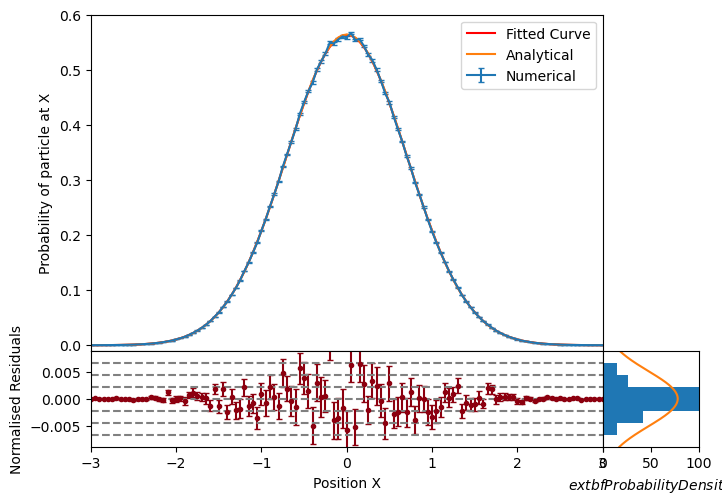

In [ ]:
#moi = generateNRandomPaths(1,0)[0]
#time = np.arange(0,T,dt)/dt
#plt.plot(moi,time)

f1 = plt.figure(1)
f1.add_axes((0,0,0.8,0.7))
plt.gca().set_ylim([-0.01,0.6])
plt.gca().set_xlim([-3,3])
plt.gca().axes.get_xaxis().set_ticks([])
plt.ylabel("Probability of particle at X")
#plt.plot(xs,Psi(paths))


chiValues = chifit(xs)
analyticalValues = wavefunc(xs)

normres = (ys-chiValues)/np.sqrt(chiValues)
reserrs = yerrs/np.sqrt(chiValues)


plt.errorbar(xs, ys, yerrs, capsize=2, label = "Numerical")#Plot the data

plt.plot(xs, chifit(xs , *popt), color='r', label = "Fitted Curve")#Plot the fitted curve

plt.plot(xs,wavefunc(xs), label = "Analytical")#plot the actual solution
plt.legend()

##########################################

j = 4

stdd = np.std(normres)

f1.add_axes((0,-0.2,0.8,0.2))
plt.gca().set_ylim([-j*stdd,j*stdd])
plt.gca().set_xlim([-3,3])


plt.ylabel("Normalised Residuals")
plt.xlabel("Position X")
stdresarray = np.ones(len(normres))*stdd
plt.errorbar( xs, normres, reserrs, fmt=".", color = "#8C000F", capsize=2)

for i in range(-j+1,j):
    plt.plot(xs,i*stdresarray, color='grey', linestyle='dashed')

#######################################

f1.add_axes((0.8,-0.2,0.15,0.2))
plt.gca().set_ylim([-j*stdd,j*stdd])
plt.gca().set_xlim([0,100])
plt.gca().axes.get_yaxis().set_ticks([])
plt.xlabel("$\textbf{Probability Density}$")
histrange = np.arange(-j*stdd,(j+1)*stdd,stdd)

plt.hist(normres, histrange, density=1, orientation = "horizontal")
#f1.add_axes((0.8,-0.4,0.15,0.2))
x = np.arange(-j*stdd,j*stdd,0.0000001)
mean = statistics.mean(x)
sd = statistics.stdev(x)
plt.plot( norm.pdf(x, mean, sd), x)

# np.arange(-j*stdd,(j+1)*stdd,0.5*stdd)


#actionarray = metropolis(100,0)
#plt.plot(np.arange(0,100,1),actionarray)
plt.show()